# <center> Marginal Fuels: Data Processing </center> 

## Read in data 

Read in marginal fuel proportions for PJM.  
Data from Monitoring Analytics, via PJM's data directory: http://www.monitoringanalytics.com/data/marginal_fuel.shtml

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import os
import re

In [2]:
# Files have a nonstandard date format, so specify format
def date_parser(key):
    # Try both different datetime formats the raw data files use.
    try:
        dt = datetime.strptime(key, '%d%b%Y:%H:%M:%S')
    except ValueError:
        dt = datetime.strptime(key, '%d%b%y:%H:%M:%S')
    return dt

# If input value is a percentage, convert to proportion.
def convert_percent(value):
    matching = re.compile('(\d+.\d+)%').match(str(value))
    return float(matching.group(1))/100 if matching else value

In [3]:
# Some fuels have different names from year to year. Construct a mapping.
fuel_renaming_dict = {'Lfg': 'Land Fill Gas', 'Miscellaneous': 'Misc', 'Msw': 'Municipal Waste'}

In [4]:
# Read in data
have_created_full_df = False
for year in range(2016, 2018):
    print(year)
    for month in range(1, 13):
        filepath = os.path.join(os.pardir, 'raw_data', str(year), '{0:}{1:02d}_Marginal_Fuel_Postings.csv'.format(year, month))
        df = pd.read_csv(filepath, index_col=0, parse_dates=[0], usecols=[0,1,2,3], date_parser=date_parser)
        df.columns = ['tz', 'FUEL_TYPE', 'PERCENT_MARGINAL'] # For consistency from year to year
        
        # In case we're given percentages (as in some years), convert to proportions.
        df['PERCENT_MARGINAL'] = df['PERCENT_MARGINAL'].map(convert_percent)
        
        # Standardize fuel type names across years (title case and consistent naming)
        df['FUEL_TYPE'] = df['FUEL_TYPE'].map(lambda x: x.lower().title())
        # Get renaming if it exists, otherwise return the existing string
        df['FUEL_TYPE'] = df['FUEL_TYPE'].map(lambda x: fuel_renaming_dict.get(x, x))
    
        if have_created_full_df:
            marg_fuels = pd.concat([marg_fuels, df], axis=0)
        else:
            marg_fuels = df.copy()
            have_created_full_df = True
print('Finished')

2016
2017
Finished


In [5]:
marg_fuels.head()

,tz,FUEL_TYPE,PERCENT_MARGINAL
HOUR,,,
2016-01-01 00:00:00,EST,Coal,0.2353
2016-01-01 00:00:00,EST,Natural Gas,0.4706
2016-01-01 00:00:00,EST,Wind,0.2941
2016-01-01 01:00:00,EST,Natural Gas,0.8000
2016-01-01 01:00:00,EST,Wind,0.2000


In [6]:
marg_fuels['FUEL_TYPE'].unique()

array(['Coal', 'Natural Gas', 'Wind', 'Land Fill Gas', 'Solar',
       'Municipal Waste', 'Waste Coal', 'Misc', 'Light Oil', 'Diesel',
       'Heavy Oil', 'Min Gen/Dispatch Reset', 'Kerosene', 'Missing Data',
       'Uranium', 'Propane'], dtype=object)

In [7]:
marg_fuels['2016-01-01':].groupby('FUEL_TYPE').sum()/(366*24)
# marg_fuels.groupby('FUEL_TYPE').mean()

,PERCENT_MARGINAL
FUEL_TYPE,
Coal,0.804108
Diesel,0.015416
Heavy Oil,0.000803
Kerosene,0.000321
Land Fill Gas,0.001843
Light Oil,0.106872
Min Gen/Dispatch Reset,0.001732
Misc,0.003852
Missing Data,0.000159


## Convert dates to UTC 

In [8]:
# Import some helper functions
os.sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))
import date_helpers

In [9]:
# Convert dates to UTC and drop time zone column
marg_fuels = date_helpers.get_df_dates_tz_to_utc(marg_fuels)
marg_fuels.drop('tz', axis=1, inplace=True)

In [10]:
# actually in UTC-5
marg_fuels.index = marg_fuels.index + timedelta(hours=-5)

## Create vector of fuel proportions 

Convert formatting so that there is one row associated with each hour, and columns indicate marginal fuel proportions.

In [11]:
# Turn each row into a vector with the appropriate proportion in the approportiate fuel column (and 0s elsewhere)
marg_fuels = pd.get_dummies(marg_fuels['FUEL_TYPE']).multiply(marg_fuels['PERCENT_MARGINAL'], axis=0)

# Sum all vectors belonging to the same date
marg_fuels = marg_fuels.groupby(marg_fuels.index).sum()

## Fix proportion sums 

In [12]:
# Get proportion sums for each hour
sums = marg_fuels.sum(axis=1)

In [13]:
# Check if all sums fall within a reasonable range (close to 1). They all do.
marg_fuels[(sums < 0.999) | (sums > 1.001)]

,Coal,Diesel,Heavy Oil,Kerosene,Land Fill Gas,Light Oil,Min Gen/Dispatch Reset,Misc,Missing Data,Municipal Waste,Natural Gas,Propane,Solar,Uranium,Waste Coal,Wind
DATE_UTC,,,,,,,,,,,,,,,,


In [14]:
# However, many sums are not exactly 1, so we need to normalize.
print('{}/{} rows do not sum to exactly 1'.format(len(sums[sums != 1]), len(marg_fuels)))

3477/17544 rows do not sum to exactly 1


In [15]:
# Normalize values to get more values to sum to exactly 1
marg_fuels2 = marg_fuels.divide(sums, axis=0)

## Bin marginal fuels

Since there are so many fuel types, we bin similar fuels (or infrequent fuels) together. 

In [16]:
# Map of fuels from current name to bin name
fuel_map = {'Coal':'Coal', 'Natural Gas':'Natural Gas', 'Wind':'Wind', 'Light Oil':'Petroleum', 
                 'Land Fill Gas':'Land Fill Gas', 'Nuclear':'Nuclear', 'Waste Coal':'Coal', 
                 'Misc':'Other', 'Uranium':'Other', 'Heavy Oil':'Petroleum',
                 'Kerosene':'Petroleum', 'Diesel':'Petroleum', 'Municipal Waste':'Other', 
                 'Interface':'Other', 'Battery':'Other', 'Min Gen/Dispatch Reset':'Other', 
                 'Missing Data':'Other', 'Solar':'Other','Demand Response':'Other', 
                 'Hydro':'Other', 'Virtual Sale At Ny':'Other', 'Virtual Sale At Miso':'Other', 
                 'Biomass': 'Other', 'Propane':'Natural Gas'}

In [17]:
marg_fuels_binned = marg_fuels2.copy()
marg_fuels_binned.columns = marg_fuels_binned.columns.map(lambda x: fuel_map[x])
marg_fuels_binned = marg_fuels_binned.groupby(marg_fuels_binned.columns, axis=1).sum()

## Check data 

In [18]:
%matplotlib inline

In [19]:
marg_fuels_binned.head()

,Coal,Land Fill Gas,Natural Gas,Other,Petroleum,Wind
DATE_UTC,,,,,,
2016-01-01 00:00:00+00:00,0.2353,0.0,0.4706,0.0,0.0,0.2941
2016-01-01 01:00:00+00:00,0.0000,0.0,0.8000,0.0,0.0,0.2000
2016-01-01 02:00:00+00:00,0.0000,0.0,0.5714,0.0,0.0,0.4286
2016-01-01 03:00:00+00:00,0.0000,0.0,0.8000,0.0,0.0,0.2000
2016-01-01 04:00:00+00:00,0.0000,0.0,0.6316,0.0,0.0,0.3684


In [20]:
marg_fuels_binned.tail()

,Coal,Land Fill Gas,Natural Gas,Other,Petroleum,Wind
DATE_UTC,,,,,,
2017-12-31 19:00:00+00:00,0.434800,0.0,0.521700,0.0,0.043500,0.0
2017-12-31 20:00:00+00:00,0.478300,0.0,0.521700,0.0,0.000000,0.0
2017-12-31 21:00:00+00:00,0.480000,0.0,0.480000,0.0,0.040000,0.0
2017-12-31 22:00:00+00:00,0.478252,0.0,0.434757,0.0,0.086991,0.0
2017-12-31 23:00:00+00:00,0.458300,0.0,0.500000,0.0,0.041700,0.0


/Users/priyadonti/anaconda2/envs/py35/lib/python3.5/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


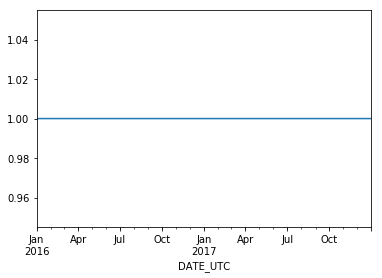

In [21]:
# All sums should be about 1. Looks good.
marg_fuels_binned.sum(axis=1).plot();